### Notebook 02: EDA

In [2]:
# Import neccessary support
import pandas as pd
import numpy as np
import cv2, os
import random

import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from zipfile import ZipFile

#import matplotlib.image as mpimg
#from tensorflow.keras.models import Sequential 
#from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
#from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image

# load VGG-16 model: 23 layers, 138,357,544 params, 528MB
from keras.applications.vgg16 import VGG16
# These models expect 
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions

In [3]:
# Load Image ID's from text file
with open('../data/dog_data_part2.txt', 'r') as imagehandles:
    # Store Image ID's as variable for image pre-processing, removing the endline character in the process
    dog_data_part2 = [image_id[:-1] for image_id in imagehandles]
# Check that all is copacetic
len(dog_data_part2), type(dog_data_part2), dog_data_part2[0], type(dog_data_part2[0])

(1240, list, '2377385', str)

### Instantiate VGG-16 Model<br>
>  Image data format: Set in Keras JSON config file<br>
> - Stored at  '~/.keras/keras.json'<br>
{<br>
    "floatx": "float32",<br>
    "epsilon": 1e-07,<br>
    "backend": "tensorflow",<br>
    "image_data_format": "channels_last"<br>
}<br><br>
- NOTE: "Channels Last = (height, width, depth)-TensorFlow data format convention<br>

#### Vizualize filters and feature maps of CNNs with VGG-16

In [18]:
# load VGG-16 model: 23 layers, 138,357,544 params, 528MB
from keras.applications.vgg16 import VGG16

# Adjust input size of the model for include_top=False
# new_input = Input(shape=(224,224,3)) --> MUST INCLUDE THIS PARAM AFTER CLASSIFICATION

# load the model weights into memory
# https://keras.io/api/applications/vgg/#vgg16-function
model_vgg16 = VGG16(
                include_top=True,   # include_top=False to load model wihtout the fully-connected output layers used to make predictions
                weights="imagenet", # Weights are downloaded automatically when instantiating a model: Keras Applications ~/.keras/models/
                input_tensor=None,  # input_tensor = new_input = Input(shape=(224,224,3))
                input_shape=None,
                pooling=None,
                classes=1000,
                classifier_activation="softmax",
            )
# Summarize the loaded model with all layers (include_top=True)
model_vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

#### Filter Summary (by network layer)

In [40]:
# VGG-16 Layers with non-zero parameters
layers_VGG16 = [ 1, 2, 4, 5, 7, 8, 9, 11, 12, 13, 15, 16, 17, 20, 21, 22 ]
# Choose a layer to perform feature extraction
layer_VGG16  = 0
# summarize filter shapes
print('Layer Summary\tKernel Size: ( K x K )\t')
print()
print('Number\t\tName\t\t(K, K, Depth, Nodes)')
# Loop thru each layer in ImageNet Model to summarize
for layer in model_vgg16.layers:
    # check for convolutional layer
    if ('conv' not in layer.name) & ('fc' not in layer.name):
        layer_VGG16 += 1
        continue # Exclude fully connected layers & return to loop beginning
    # get filter weights
    filters, biases = layer.get_weights()
    print(f'Layer {layer_VGG16}:\t{layer.name}\t{filters.shape}')
    layer_VGG16 += 1
print()

# Select layer from VGG-16 layers list above to retrieve weights
layer_number = layers_VGG16[0]
# Retrieve current weights from selected hidden layer: 'layer_number'
# Weights rep state of layer, get_weights loads state into similarly parameterized layers
filters_extract, biases_extract = model_vgg16.layers[layer_number].get_weights()
print(f'Layer {layer_number}: {filters_extract.shape}')

Layer Summary	Kernel Size: ( K x K )	

Number		Name		(K, K, Depth, Nodes)
Layer 1:	block1_conv1	(3, 3, 3, 64)
Layer 2:	block1_conv2	(3, 3, 64, 64)
Layer 4:	block2_conv1	(3, 3, 64, 128)
Layer 5:	block2_conv2	(3, 3, 128, 128)
Layer 7:	block3_conv1	(3, 3, 128, 256)
Layer 8:	block3_conv2	(3, 3, 256, 256)
Layer 9:	block3_conv3	(3, 3, 256, 256)
Layer 11:	block4_conv1	(3, 3, 256, 512)
Layer 12:	block4_conv2	(3, 3, 512, 512)
Layer 13:	block4_conv3	(3, 3, 512, 512)
Layer 15:	block5_conv1	(3, 3, 512, 512)
Layer 16:	block5_conv2	(3, 3, 512, 512)
Layer 17:	block5_conv3	(3, 3, 512, 512)
Layer 20:	fc1	(25088, 4096)
Layer 21:	fc2	(4096, 4096)

Layer 1: (3, 3, 3, 64)


In [70]:
# (kernel-height, kernel-width, channel-depth, No. of filters)
# 64-filters each (3 x 3 x 3) 3D volume, cubic filters
filters_extract.shape, type(filters_extract)

((3, 3, 3, 64), numpy.ndarray)

In [227]:
filters_extract[0][0].shape, filters_extract.min(3),

((3, 64),
 array([[[0.2410788 , 0.14405024, 0.17188708],
         [0.21905349, 0.13779737, 0.1578574 ],
         [0.22949417, 0.12949093, 0.16341406]],
 
        [[0.22994165, 0.14908592, 0.17978509],
         [0.1863384 , 0.16121466, 0.18800756],
         [0.11930275, 0.        , 0.04622722]],
 
        [[0.22533065, 0.14236566, 0.17052189],
         [0.20956579, 0.09347925, 0.15874107],
         [0.22243272, 0.13306199, 0.17015679]]], dtype=float32))

In [220]:
 filters_extract.max(3)

array([[[0.8601116 , 0.9545779 , 0.89960235],
        [0.915383  , 1.        , 0.96599036],
        [0.8567038 , 0.97389966, 0.925328  ]],

       [[0.810127  , 0.86608565, 0.84025717],
        [0.90729994, 0.9373233 , 0.91953784],
        [0.87189955, 0.9382962 , 0.90447164]],

       [[0.779941  , 0.8438289 , 0.8172243 ],
        [0.8836065 , 0.9460532 , 0.92962444],
        [0.8408625 , 0.8799469 , 0.8426137 ]]], dtype=float32)

#### Visualize Second Layer (First Conv2D Layer immediately following the input layer)

	Layer 1:  FILTER #


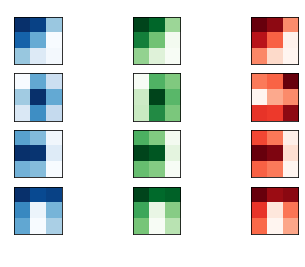

In [82]:
# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters_extract.min(), filters_extract.max()
# Sets the minimum to zero and the maximum to one
filters_extract = (filters_extract - f_min) / (f_max - f_min)

# plot first few filters
n_filters, ix = 4, 1
for i in range(n_filters):
    # get the filter
    f = filters_extract[:, :, :, i]
    # plot each channel separately
    for j in range(3):
        # specify subplot and turn of axis
        if j == 0:
            c = '\nBLUE'
            color_map = 'Blues'
        elif j == 1:
            c = '\nGREEN'
            color_map = 'Greens'
        else:
            c ='\nRED'
            color_map = 'Reds'
        ax = plt.subplot(n_filters, 3, ix, fc='grey')
        ax.set_xticks([])
        ax.set_yticks([])
        plt.xlabel(xlabel=c,color='w')
        plt.ylabel(ylabel=f'  \n\n{i+1}',color='w',rotation=0)
        # plot filter channel in grayscale
        plt.imshow(f[:, :, j], cmap=color_map)
        ix += 1
#print('\t\t FILTER #')
print(f'\tLayer {layer_number}:  FILTER #')

#### Test Visual Genome Dog Data, chosen at random, on VGG-16 Loaded Weights

In [228]:
# NOTICE, SOME CODE IN THIS CELL FROM:
# https://thispointer.com/python-how-to-get-the-list-of-all-files-in-a-zip-archive/

# Input shape acrandom_dogby VGG-16 = 224 x 224 x3
img_height = 224
img_width = 224

# Choose a dog randomly to test breed accuracy
dog_pic_x = random.randint(0, len(dog_data_part2)-1)
random_dog = int(dog_data_part2[dog_pic_x])

# ~5.5 GB ZIP Archive, 40% of total data set
# Open, read, and close ZIP file for faster image pre-processing
with ZipFile('../../visual_genome_part2.zip', "r") as z:
    # One file in zip archive
    VG_100K_2 = z.namelist()

    # Iterate over image file names, 'VG_100K_2/image_id.jpg'
    for ith_image in VG_100K_2: 
        # Get extension of file, '.jpg'
        ext = os.path.splitext(ith_image)[-1]
        # Get root of file, root = VG_100K_2/image_id.jpg
        root = os.path.splitext(ith_image)[0]
        
        # Skip over Archive Directory
        if (ext == ".jpg"):
            
            # Skip root[:10]='VG_100K_2' in dog_pic_ids
            if int(root[10:]) == random_dog:
                
                # Read image binary data of 'VG_100K_2' from zip archive('visual_genome_part2.zip')
                in_bytes = z.read(ith_image) # VG_100K_2/
                # Decode bytes to image
                img = cv2.imdecode(np.frombuffer(in_bytes, np.uint8), cv2.IMREAD_COLOR)
                # Input shape accepted by VGG-16 = 224 x 224 x3
                img = cv2.resize(img, dsize=(img_width, img_height))
                # Convert a PIL image instance to a Numpy array
                dog_x = image.img_to_array(img)
                # Expand the shape of the array: Insert new axis at 'axis' position in expanded array shape
                dog_x = np.expand_dims(dog_x, axis=0)
                # Returns array with type: 'float32', covert: RGB --> BGR, & zero-center each channel wrt ImageNet dataset
                dog_x = preprocess_input(dog_x)
                
                # Extract features from image_id = dog_x with VGG-16
                preds = model_vgg16.predict(dog_x)

                # Decode extracted features into class, description, and probability
                preds_class_breed_score = decode_predictions(preds, top=5)[0]
                
                # Display the prediction corresponding to the image
                print(f'Prediction: (for random dog = {random_dog}) \n')
                for i in range(len(preds_class_breed_score)):
                    print(f'\t{preds_class_breed_score[i][2]*100:.2f}%\t:{preds_class_breed_score[i][1]}')

                # Output img with window name as 'image' 
                cv2.imshow('img', img)
                
                # Display for 30 secs = 1_000ms * 30
                #cv2.waitKey(30*1000)
                
                # Display image indefinitely
                cv2.waitKey(0)

cv2.destroyAllWindows()

Prediction: (for random dog = 2382269) 

	45.91%	:marimba
	9.28%	:stage
	8.05%	:container_ship
	4.88%	:palace
	4.32%	:panpipe


In [ ]:
#model.save('/../assets/model.h5')

print("Saved model to disk")
#del model

In [88]:
img_path = '../../visual_genome_part2/VG_100K_2/2405343.jpg'
img = image.load_img(img_path, target_size=(224, 224))
dog_x = image.img_to_array(img)
dog_x = np.expand_dims(dog_x, axis=0)
dog_x = preprocess_input(dog_x)

# Extract features from image_id = dog_x with VGG-16
preds = model_vgg16.predict(dog_x)

# Decode extracted features into class, description, and probability

preds_class_breed_score = decode_predictions(preds, top=5)[0]
print('Prediction: \n')
for i in range(len(preds_class_breed_score)):
    print(f'\t{preds_class_breed_score[i][2]*100:.2f}%\t:{preds_class_breed_score[i][1]}')

Prediction: 

	37.11%	:keeshond
	13.47%	:schipperke
	8.45%	:Newfoundland
	7.30%	:groenendael
	6.35%	:Norwegian_elkhound
